# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
# from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

In [2]:
# import sys
# !{sys.executable} -m pip install netcdf4

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [3]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64[ns]")

In [4]:
# This is the catalog with all details from the USGS Earthquake Catalog

original_catalog = pd.read_csv('19970101-20220116.csv')
original_catalog = original_catalog[original_catalog['time']>'2002-04-16']
original_catalog = original_catalog[original_catalog['time']<'2022-01-16']
cat = original_catalog.reset_index()

In [5]:
depth = cat['depth']
catalog['depth'] = depth

## 2. Using Mizrahi's ETAS code, filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [6]:
etas_declustered = catalog[catalog['P_triggered']<.9]

## 3. Add surface load data to the earthquake dataframes

In [61]:
etas_declustered = pd.read_csv('etas_declustered.csv')
catalog = pd.read_csv('catalog.csv')

## 4. Analyze correlation between all events and surface mass loading by mascon

### What we previously did:

Conditional probability for each event is the P(L|E) divided by P(L). The L|E are the loads at the times of an earthquake, while L are the loads at all times globally. 

`def get_cond_probability(all_time_periods, earthquake_only, loads, method):`
    
    cp,bins = calculate_bayes(earthquake_only,all_time_periods,method)

    cp_for_each_event = []
    
    for load in loads:
        
        this_bin = bins[0]
        i = 0
        while this_bin < load:
            if i == len(cp):
                break
            else:
                i = i + 1
                this_bin = bins[i]
        cp_for_each_event.append(cp[i-1])
        
    return np.array(cp_for_each_event)
    

`def calculate_bayes(earthquake_only,all_time_periods,method):`

    bins = calculate_bin_sizes(earthquake_only,method)

    LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
    L   = np.histogram(all_time_periods,bins=bins, density = True)[0]
    cp = LgE/L

    return cp, bins


###  This method calculates LgE and L by mascon.

In [14]:
def calculate_probabilities_by_mascon(all_time_periods, earthquake_only, ds):
    
    lat_bounds = ds['lat_bounds'].data
    lon_bounds = ds['lon_bounds'].data
    
    LgE_list = []
    L_list = []

    for lat_idx in range(len(lat_bounds)):
        for lon_idx in range(len(lon_bounds)):
            
            lat_min, lat_max = lat_bounds[lat_idx]
            lon_min, lon_max = lon_bounds[lon_idx]

            # Find all earthquakes that fall within the current mascon bounds
            earthquakes_in_mascon = earthquake_only[
                (earthquake_only['latitude'] >= lat_min) &
                (earthquake_only['latitude'] <= lat_max) &
                (earthquake_only['longitude'] >= lon_min) &
                (earthquake_only['longitude'] <= lon_max)
            ]
            
            if len(earthquakes_in_mascon) > 0:
                LgE_for_each = earthquakes_in_mascon['dmass'].tolist()
            else:
                continue  # Skip this mascon if no earthquakes are found

            # Extract load data (L) for the current mascon (all time periods)
            lwe_grid = all_time_periods.isel(lat=lat_idx, lon=lon_idx).data.flatten()
            
            LgE_list.append(LgE_for_each)  # P(L|E) for each mascon
            L_list.append(lwe_grid)  # P(L) for each mascon

    return LgE_list, L_list

In [114]:
def get_cp(LgE_list, L_list, method):
    cp_list = []  
    
    bins = loadquakes.calculate_bin_sizes(LgE_list, method)
    
    for i in range(len(LgE_list)):
        LgE = np.array(LgE_list[i])
        L = np.array(L_list[i])

        LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
        L_hist = np.histogram(L, bins=bins, density=True)[0]

        cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

        cp_list.append(cp)

    return bins, cp_list  #  list of cps for all mascons that contain earthquakes

In [80]:
def aggregate_cp(cp_list):
    
    """
    Aggregates the conditional probabilities from each mascon by summing them.
    """

    ref = len(cp_list[0])
    aggregated_cp = np.zeros(ref)

    # Loop through each mascon's cp and sum them up
    for cp in cp_list:
        if len(cp) == ref:
            aggregated_cp += cp
        else:
            print('wrong size!')

    return aggregated_cp

In [89]:
def assign_cp(all_time_periods, earthquake_only, cp):
    
    loads = earthquake_only.dmass
    cp_for_each_event = []
    
    for load in loads:
        
        this_bin = bins[0]
        i = 0
        while this_bin < load:
            if i == len(cp):
                break
            else:
                i = i + 1
                this_bin = bins[i]
        cp_for_each_event.append(cp[i-1])
        
    return np.array(cp_for_each_event)

### I. ETAS declustered

In [70]:
LgE_list, L_list = calculate_probabilities_by_mascon(ds['lwe_thickness'], etas_declustered, ds)

In [116]:
bins, cp_list = get_cp(LgE_list, L_list, 'fd')

In [118]:
aggregated_cp = aggregate_cp(cp_list)

In [119]:
cp_for_each_event = assign_cp(ds['lwe_thickness'], etas_declustered, aggregated_cp)

In [120]:
etas_declustered.loc[:, 'cp_by_mascon'] = cp_for_each_event

Text(0.5, 1.0, 'Histogram of event conditional probabilities')

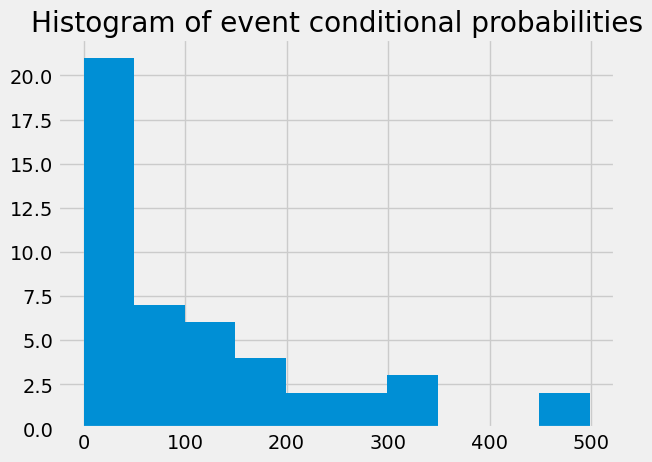

In [128]:
# ETAS declustered

fig,ax=plt.subplots()
plt.hist(aggregated_cp)
plt.title('Histogram of event conditional probabilities')
# plt.yscale('log')

#### The conditional probability will change quantitatively depending on the bin size. However, the same qualitative distribution remains, where there is a higher relative conditional probability during periods of large loading and unloading. 

#### Here, we calculate the Bayesian probability using two different bin sizes which are calculated via two methods:

##### a. Sturge's Rule
##### b. Freedman-Diaconis Rule


In [122]:
def plot_bayes_mascon(ax, earthquake_only, title, xlab, method, fs):
    plt.style.use('fivethirtyeight')
    
    bins = loadquakes.calculate_bin_sizes(LgE_list, method) 
    wid = np.mean(np.diff(bins))
    
    print(len(bins))
    print(len(aggregated_cp))
    
    ax.bar(bins[:-1], aggregated_cp, width=wid, align='edge')

    xl = ax.get_xlim()
    ax.set_xlim(xl[0], xl[1] - 4.4)
    ax.set_xlabel(xlab, fontsize=fs)
    ax.set_ylabel('Conditional probability', fontsize=fs)
    ax.set_title(title, fontsize=fs)
    ax.grid

48
47


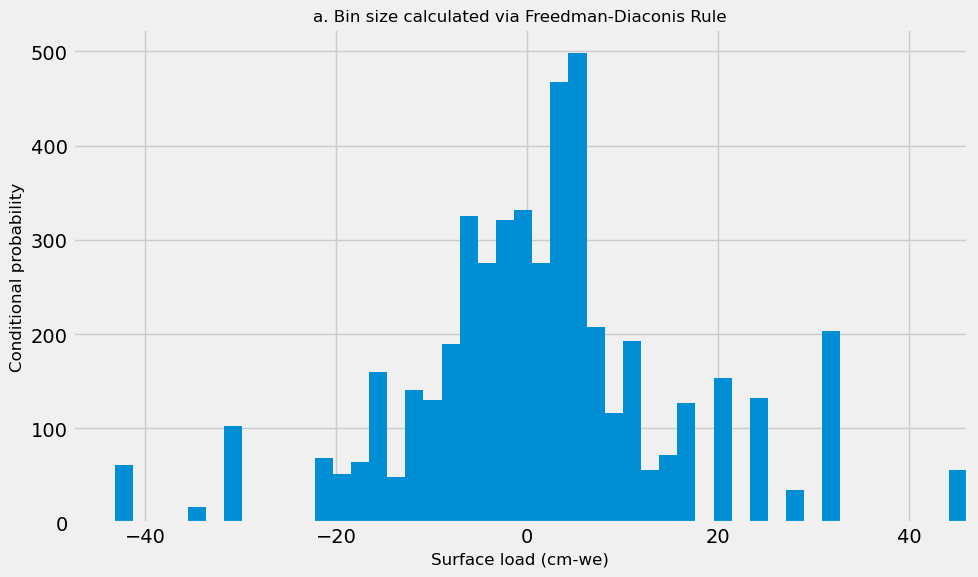

In [123]:
importlib.reload(loadquakes)
fig,ax = plt.subplots(figsize=(10,6))

plt.style.use('fivethirtyeight')

plot_bayes_mascon(ax, np.array(etas_declustered.dmass), 
                  "a. Bin size calculated via Freedman-Diaconis Rule", 
                  'Surface load (cm-we)', 
                  method='fd', fs=12)

fig.tight_layout()

### II. Full catalog

In [17]:
# LgE_list, L_list = calculate_probabilities_in_mascons(ds['lwe_thickness'], catalog, method='fd')
# cp_for_each_event, cp = get_cp_in_mascon(np.array(catalog.dmass), 'fd')

# catalog.loc[:, 'cp_mascon'] = cp_for_each_event

# catalog

In [18]:
# full catalog

# fig,ax=plt.subplots()
# plt.hist(catalog.cp_mascon,11)
# plt.title('Histogram of event conditional probabilities')
# plt.yscale('log')

In [19]:
# importlib.reload(loadquakes)
# fig,(ax1,ax2) = plt.subplots(1,2, figsize=(17,6))

# plt.style.use('fivethirtyeight')

# plot_bayes_mascon(ax1, np.array(catalog.dmass), 
#                   "a. Bin size calculated via Sturge's Rule", 
#                   'Surface load (cm-we)', 
#                   method='Sturge', fs=12)

# plot_bayes_mascon(ax2, np.array(catalog.dmass), 
#                   "a. Bin size calculated via Freedman-Diaconis Rule", 
#                   'Surface load (cm-we)', 
#                   method='fd', fs=12)

# fig.tight_layout()